# Pruning Convolutional Neural Networks

### Introduction  
In deep learning, a convolutional neural network is a class of deep neural networks, most
commonly applied to analyzing visual imagery. Usually when we build a Convolution Neural
Network with large number of neurons it can achieve the state-of-the-art performance for
variety of computer vision tasks, but how large or deep a neural network can be, that is still a
question. In this notebook we are trying to find the optimum number of neurons in a network so
that it can retain its accuracy even when we reduce the network size. There are various pruning
techniques to reduce the network architecture, we will try to remove the neurons with small
weights and low variances. When we prune a neural network, there is a trade-off between
accuracy and network size. Generally larger the network size better the performance but it also
requires more computational power and cost. We are trying to reduce the computational
power and cost by reducing the size of the network so that it can run on CPU’s and mobile
devices.  

We are trying to reduce the network architecture and parameters of a CNN model that has
been created by us and it is trained on CIFAR-10 dataset. For this project we are pruning only
the last layer i.e. the dense layer which has large number of neurons and try to maintain the
accuracy that the original model has achieved.
Our focus will be to study the behavior of each neuron once it is trained, we will try to find the
neurons that are inactive or not participating in image classification and remove them from the
network. Since, we are creating a CNN model with 2 convolution layers and 3 fully connected
layers, the network size is around 5MB which is already small, can we make it smaller without
making it worse that is the biggest question?  

The success of this research will be measured by comparing the Initial Accuracy vs Accuracy
after the pruning and Initial Network Size vs Network Size after pruning. It is still an open
question in machine learning to find the optimum number of neurons that is required to train
any model for image classification.  


### Dataset

We have used CIFAR-10 dataset for training and validating the accuracy for CNN model. The
dataset can be downloaded from the below link  
CIFAR-10: https://www.cs.toronto.edu/~kriz/cifar.html


#### Importing libraries and dataset

The following libraries are required to run the below code

In [0]:
from __future__ import print_function
import keras
from keras.datasets import cifar10
from tensorflow.contrib.keras import layers
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.callbacks import ModelCheckpoint
import os
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
!pip install -U -q keras_sequential_ascii
from keras_sequential_ascii import sequential_model_to_ascii_printout
import glob
import math

Using TensorFlow backend.


#### Setting up inital variables

Setting the initial variables and creating the training and testing sample of the dataset 

In [0]:
batch_size = 100
num_classes = 10
epochs = 30
data_augmentation = False
num_predictions = 20
include_zeros = False

# The data, split between train and test sets:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

# Convert class vectors to binary class matrices.
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

x_train shape: (50000, 32, 32, 3)
50000 train samples
10000 test samples


### Helper Functions

In [0]:
def create_model(x_train,y_train,x_test, y_test): 
  """
  input: train and test data
  output: model, the hidden layers, the fully connected layers
  
  The function takes the data as input and creates a CNN model with 
  2 convolutional layers and 3 dense layers of different shapes
  
  It also saves the weights of the model after each epoch.
  """
  model = Sequential()
  conv_1 = Conv2D(32, (3, 3), activation='relu', padding='same',
                   input_shape=x_train.shape[1:])
  model.add(conv_1)
  # conv_2 = Conv2D(32, (3, 3), activation='relu')
  # model.add(conv_2)
  model.add(MaxPooling2D(pool_size=(2, 2)))
  model.add(Dropout(0.25))

  conv_2 = Conv2D(64, (3, 3), activation='relu', padding='same')
  model.add(conv_2)
  # conv_4 = Conv2D(64, (3, 3), activation='relu')
  # model.add(conv_4)
  model.add(MaxPooling2D(pool_size=(2, 2)))
  model.add(Dropout(0.25))

  model.add(Flatten())
  dense1 = Dense(128, activation='relu')
  model.add(dense1)
  dense2 = Dense(256, activation='relu')
  model.add(dense2)
  dense3 = Dense(512, activation='relu')
  model.add(dense3)
  model.add(Dropout(0.5))
  model.add(Dense(num_classes))
  model.add(Activation('softmax'))

  # initiate RMSprop optimizer
  opt = keras.optimizers.rmsprop(lr=0.0001, decay=1e-6)

  # Let's train the model using RMSprop
  model.compile(loss='categorical_crossentropy',
                optimizer=opt,
                metrics=['accuracy'])

  x_train = x_train.astype('float32')
  x_test = x_test.astype('float32')
  x_train /= 255
  x_test /= 255

  filepath="weights-{epoch:02d}.hdf5"
  checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=False,save_weights_only=True ,mode='max')
  callbacks_list = [checkpoint]

  if not data_augmentation:
      print('Not using data augmentation.')
      model.fit(x_train, y_train,
                batch_size=batch_size,
                epochs=epochs,
                validation_data=(x_test, y_test),
                callbacks=callbacks_list,
                shuffle=True)
  else:
      print('Using real-time data augmentation.')
      # This will do preprocessing and realtime data augmentation:
      datagen = ImageDataGenerator(
          featurewise_center=False,  # set input mean to 0 over the dataset
          samplewise_center=False,  # set each sample mean to 0
          featurewise_std_normalization=False,  # divide inputs by std of the dataset
          samplewise_std_normalization=False,  # divide each input by its std
          zca_whitening=False,  # apply ZCA whitening
          zca_epsilon=1e-06,  # epsilon for ZCA whitening
          rotation_range=0,  # randomly rotate images in the range (degrees, 0 to 180)
          # randomly shift images horizontally (fraction of total width)
          width_shift_range=0.1,
          # randomly shift images vertically (fraction of total height)
          height_shift_range=0.1,
          shear_range=0.,  # set range for random shear
          zoom_range=0.,  # set range for random zoom
          channel_shift_range=0.,  # set range for random channel shifts
          # set mode for filling points outside the input boundaries
          fill_mode='nearest',
          cval=0.,  # value used for fill_mode = "constant"
          horizontal_flip=True,  # randomly flip images
          vertical_flip=False,  # randomly flip images
          # set rescaling factor (applied before any other transformation)
          rescale=None,
          # set function that will be applied on each input
          preprocessing_function=None,
          # image data format, either "channels_first" or "channels_last"
          data_format=None,
          # fraction of images reserved for validation (strictly between 0 and 1)
          validation_split=0.0)

      # Compute quantities required for feature-wise normalization
      # (std, mean, and principal components if ZCA whitening is applied).
      datagen.fit(x_train)

      # Fit the model on the batches generated by datagen.flow().
      model.fit_generator(datagen.flow(x_train, y_train,
                                       batch_size=batch_size),
                          epochs=epochs,
                          validation_data=(x_test, y_test),
                          workers=4)

  # Save initial model
  model.save('./init_model.h5')


  # Score trained model.
  scores = model.evaluate(x_test, y_test, verbose=1)
  print('Test loss:', scores[0])
  print('Test accuracy:', scores[1])
  return model, conv_1,conv_2,dense1,dense2,dense3


 
def create_new_model(new_outShape, x_train, y_train,x_test,y_test,conv1_w, conv2_w, dense1_w, dense2_w, dense3_w_new):
  """
  input: train and test data, new shape of last dense layer, weights from pre trained model
  output: model
  
  The function takes the data and weihgts from pretrained model as input and 
  creates a new CNN model similar to the pretrained model with only difference in the 
  shape and the weights of the last dense layer
  """
  new_model = Sequential()
  conv_1 = Conv2D(32, (3, 3), activation='relu', padding='same',
                   input_shape=x_train.shape[1:])
  new_model.add(conv_1)
  new_model.add(MaxPooling2D(pool_size=(2, 2)))
  new_model.add(Dropout(0.25))

  conv_2 = Conv2D(64, (3, 3), activation='relu', padding='same')
  new_model.add(conv_2)
  new_model.add(MaxPooling2D(pool_size=(2, 2)))
  new_model.add(Dropout(0.25))

  new_model.add(Flatten())
  dense1 = Dense(128, activation='relu')
  new_model.add(dense1)
  dense2 = Dense(256, activation='relu')
  new_model.add(dense2)
  dense3 = Dense(new_outShape, activation='relu')
  new_model.add(dense3)
  new_model.add(Dropout(0.5))
  new_model.add(Dense(num_classes))
  new_model.add(Activation('softmax'))

  # initiate RMSprop optimizer
  opt = keras.optimizers.rmsprop(lr=0.0001, decay=1e-6)

  # Let's train the model using RMSprop
  new_model.compile(loss='categorical_crossentropy',
                optimizer=opt,
                metrics=['accuracy'])

  #setting weights of layers obtained from previuosly trained model
  conv_1.set_weights(conv1_w)
  conv_2.set_weights(conv2_w)
  dense1.set_weights(dense1_w)
  dense2.set_weights(dense2_w)
  #setting weights of last dense layer with new weights obtained after removing low variance neurons 
  dense3.set_weights(dense3_w_new)
  new_model.save('./pruned_model.h5')


  # Score trained model.
  scores = new_model.evaluate(x_test, y_test, verbose=1)
  print('Test loss:', scores[0])
  print('Test accuracy:', scores[1])
  
  return new_model


#distribution plot
def dist_plot(x, plt_range):
  """
  function to plot distribution of variances and weights of neurons
  """
  fig = plt.figure(figsize=(10, 7))
  ax = fig.add_subplot(111)

  ax.hist(x,
          bins=100,
          facecolor='red',
          edgecolor='black',
          alpha=0.7,
          range=plt_range)
  return ax

 
def retrain_new_model(new_model):
  """
  input: model
  
  This function retrains the model for less number of epochs 
  and prints the test accuracy and test loss of the model 
  """
  #tuning the pruned model for less epochs
  new_model.fit(x_train, y_train,
                batch_size=batch_size,
                epochs=10,
                validation_data=(x_test, y_test),
                shuffle=True)

  new_model.save('./tuned_model.h5')
  #print('Saved trained model at %s ' % model_path)

  # Score trained model.
  scores = new_model.evaluate(x_test, y_test, verbose=1)
  print('Test loss:', scores[0])
  print('Test accuracy:', scores[1])

### Pruning the network by removing low variance neurons  

We will be calculating the variance of each neuron weights after every epoch and will remove
the neuron that has low variance. The Idea behind this approach is to check whether the weight
of a neuron is changing over time or not, if the weight is not changing after several epochs that
implies that the neuron is not getting trained and it will not have any impact in classifying the
images.  

**Extracting Variance**: Initially we start with training the CNN model on CIFAR-10 dataset and
check the accuracy of the model, by this time all the weights and bias values are adjusted to
minimize the error. We have extracted the weights in a separate file by keeping the
ModelCheckPoint’s save_weights_only function as true. Once the weights are saved for all
epochs we iterate through the files to extract the weights and using these values we are
calculating the variance.  

**Threshold**: Defining a threshold and removing all the weights which are below the threshold.
**Threshold = (minimum Variance + Maximum Variance) / 2  **

**Indexing of Neurons**: Removing neurons directly from the network would not solve our
problem, we need to remove the specific neurons with the zero variance and for that we have
extracted the index of each neurons of the dense3 layer and using the index values we have
removed the neurons from the network.


Creating the CNN model with 2 convolutional layers and 3 dense layers 

In [0]:
model , conv_1, conv_2, dense1, dense2, dense3 = create_model(x_train,y_train,x_test,y_test)

Not using data augmentation.
Train on 50000 samples, validate on 10000 samples
Epoch 1/30
50000/50000 [==============================] - 11s 211us/step - loss: 1.9978 - acc: 0.2523 - val_loss: 1.7602 - val_acc: 0.3740

Epoch 00001: saving model to weights-01.hdf5
Epoch 2/30
50000/50000 [==============================] - 8s 165us/step - loss: 1.6840 - acc: 0.3814 - val_loss: 1.5545 - val_acc: 0.4410

Epoch 00002: saving model to weights-02.hdf5
Epoch 3/30
50000/50000 [==============================] - 8s 166us/step - loss: 1.5400 - acc: 0.4351 - val_loss: 1.4279 - val_acc: 0.4887

Epoch 00003: saving model to weights-03.hdf5
Epoch 4/30
50000/50000 [==============================] - 8s 164us/step - loss: 1.4471 - acc: 0.4727 - val_loss: 1.3605 - val_acc: 0.5124

Epoch 00004: saving model to weights-04.hdf5
Epoch 5/30
50000/50000 [==============================] - 8s 164us/step - loss: 1.3708 - acc: 0.5031 - val_loss: 1.3103 - val_acc: 0.5303

Epoch 00005: saving model to weights-05.hdf5


Once the model is created and trained for 30 epochs, the shape of the last dense layer and inital weights of each layer is stored


In [0]:
#storing initial weights for each layer
conv1_w = conv_1.get_weights()
conv2_w = conv_2.get_weights()
dense1_w = dense1.get_weights()
dense2_w = dense2.get_weights()
dense3_w = dense3.get_weights()

#getting shape of last dense layer
input_shape = dense3.input_shape[1]
output_shape = dense3.output_shape[1]

The mean variance of each neuron is calculated using the weights stored after each epoch.

In [0]:
#importing the weights file stored for each epoch 
files = glob.glob('*.hdf5')

#calculating variance of each neuron for each epoch
epoch_variance = []
for file in files:
  model.load_weights(file)
  W = dense3.get_weights()[0]
  l1 = np.var((W), axis=(0))
  epoch_variance.append(l1)

  
#calculating mean variance for each neuron 
variances = []
for i in range(len(epoch_variance[0])):
  neuron_variance = []
  for j in range(len(epoch_variance)):
    neuron_variance.append(epoch_variance[j][i])
  mean_var = np.mean(neuron_variance)
  variances.append(mean_var)

Text(0,0.5,'Number of Neurons')

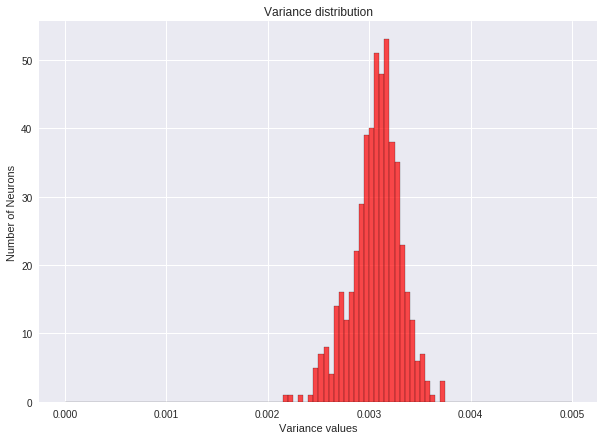

In [0]:
#plot initial variance distribution
ax = dist_plot(variances,plt_range= (0, 0.005))
ax.set_title('Variance distribution')
ax.set_xlabel('Variance values')
ax.set_ylabel('Number of Neurons')

The above plot shows the distribution of variance for the last layer neurons

The threshold is decided as mean of the minimum and maximum value of the variance. Based on that threshold , the low variance are masked to zero and the weights corresponding to those low variances are removed from the original weight matrix

In [0]:
#masking the neurons with low variance , setting threshold as mean of min and max variance
min_var = min(variances)
max_var = max(variances)
pruning_threshold = (min_var + max_var )/2
variances = np.asarray(variances)
small_variance = (variances < pruning_threshold)
small_variance = np.logical_not(small_variance)
new_variances = variances * small_variance

Text(0,0.5,'Number of Neurons')

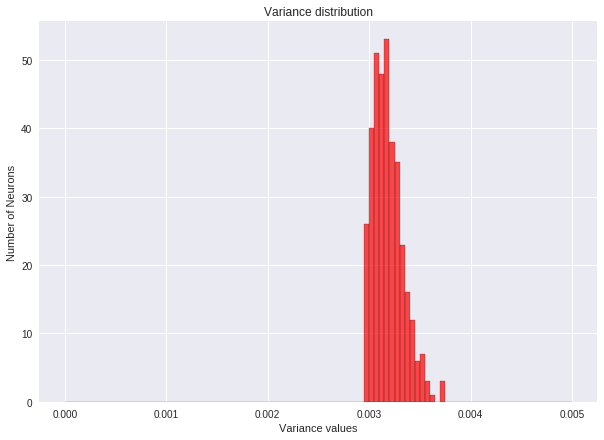

In [0]:
#plot new variance distribution
new_var = []
for v in new_variances:
    new_var.extend(list(v.ravel()))
if not include_zeros:
   new_var = [w for w in new_var if w != 0]
    
ax = dist_plot(new_var, plt_range= (0, 0.005))
ax.set_title('Variance distribution')
ax.set_xlabel('Variance values')
ax.set_ylabel('Number of Neurons')

The above plot shows the new distribution of variances

In [0]:
# getting index of neurons with zero variance
get_indexes = lambda x, xs: [i for (y, i) in zip(xs, range(len(xs))) if x == y]
zero_index_var = (get_indexes(0,new_variances))

num_zeroVarNeurons = len(zero_index_var)
new_outShape = output_shape - num_zeroVarNeurons
#removing neurons with zero variance from original matrix 
get_rem = lambda x,y:[z for(z,i) in zip(x, range(len(x))) if i not in y]
dense_w_new = np.empty((input_shape,new_outShape))
for x,i in zip(dense3_w[0], range(len(dense3_w[0]))):
  red_weights = (get_rem(x,zero_index_var))
  #print(len(red_weights))
  dense_w_new[i] =  red_weights

#removing bias for neurons with zero variance
new_bias = np.empty((new_outShape,))
x = dense3_w[1]
new_bias = (get_rem(x,zero_index_var))
new_bias = np.asarray(new_bias)

Text(0,0.5,'Number of Weights')

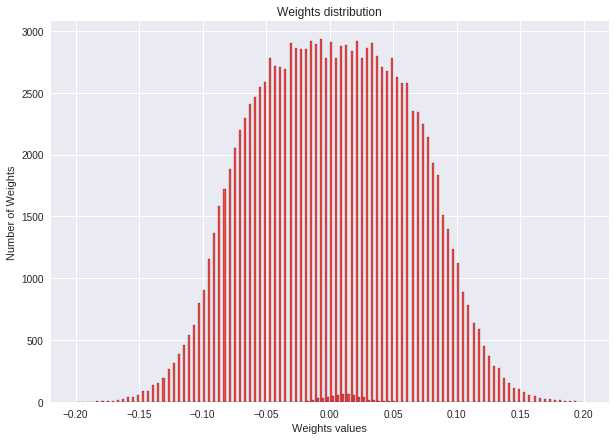

In [0]:
#plot initial weight distribution
ax = dist_plot(dense3_w, plt_range= (-0.2, 0.2))
ax.set_title('Weights distribution')
ax.set_xlabel('Weights values')
ax.set_ylabel('Number of Weights')

The above plot shows the initial distribution of weights and the number of neurons

In [0]:
#new weights for the last dense layer 
dense3_w_new = dense3_w
dense3_w_new[0] = dense_w_new
dense3_w_new[1] = new_bias

Text(0,0.5,'Number of Weights')

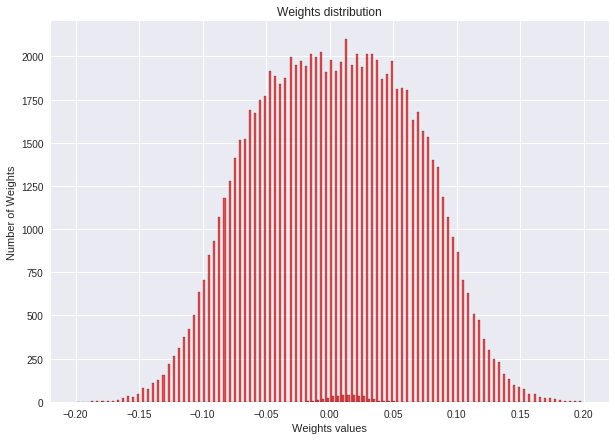

In [0]:
#plot new weight distribution
ax = dist_plot(dense3_w_new,plt_range= (-0.2, 0.2))
ax.set_title('Weights distribution')
ax.set_xlabel('Weights values')
ax.set_ylabel('Number of Weights')

The number of weights have reduced after removing the low variance neurons is evident from the above plot 

In [0]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 32, 32, 32)        896       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 16, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 16, 16, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 8, 8, 64)          0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 8, 8, 64)          0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 4096)              0         
__________

The new model is created with different shape of last dense layers which is determined by the number of neurons removed for low variance. 

In [0]:
#Creating new CNN model by changing the shape of last dense layer
new_model = create_new_model(new_outShape, x_train, y_train, x_test, y_test,conv1_w, conv2_w, dense1_w, dense2_w, dense3_w_new)

10000/10000 [==============================] - 1s 146us/step
Test loss: 13.358279342651366
Test accuracy: 0.1189


#### Retraining the model   
Removing the neurons makes the accuracy of the network worse as we are throwing away what the network has learnt , even if it did not have much importance. In order to compensate for this , we need to retrain the model. 

Retraining is done by model.fit(). Here we retrain for less number of epochs and lower learning rate as the model is already trained,we only want to make small changes to tweak the results.

In [0]:
#retrain new model
retrain_new_model(new_model)

Train on 50000 samples, validate on 10000 samples
Epoch 1/10
50000/50000 [==============================] - 12s 239us/step - loss: 8.7760 - acc: 0.4144 - val_loss: 6.0423 - val_acc: 0.5861
Epoch 2/10
50000/50000 [==============================] - 11s 221us/step - loss: 5.9630 - acc: 0.5702 - val_loss: 4.1554 - val_acc: 0.6062
Epoch 3/10
50000/50000 [==============================] - 11s 229us/step - loss: 2.2114 - acc: 0.5357 - val_loss: 1.1736 - val_acc: 0.6263
Epoch 4/10
50000/50000 [==============================] - 12s 231us/step - loss: 1.1866 - acc: 0.6160 - val_loss: 1.0286 - val_acc: 0.6710
Epoch 5/10
50000/50000 [==============================] - 12s 239us/step - loss: 1.0713 - acc: 0.6519 - val_loss: 1.0111 - val_acc: 0.6734
Epoch 6/10
50000/50000 [==============================] - 11s 220us/step - loss: 1.0070 - acc: 0.6724 - val_loss: 0.9916 - val_acc: 0.6892
Epoch 7/10
50000/50000 [==============================] - 11s 218us/step - loss: 0.9562 - acc: 0.6861 - val_loss: 0.

In [0]:
new_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 32, 32, 32)        896       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 16, 16, 32)        0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 16, 16, 64)        18496     
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 8, 8, 64)          0         
_________________________________________________________________
dropout_5 (Dropout)          (None, 8, 8, 64)          0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 4096)              0         
__________

### Results
-----------------------------------------------------------------------------------------------------
|        | Inital Model          | Pruned Model  |
| ------------- |:-------------:| -----:|
| Network Size| 5616Kb |5061Kb |
| Number of Parametrs     | 713,546    |  636,116|
| Accuracy | 71.87%    |    69.01% |

**Summary**   
Network size is reduced by **600kb**  
Accuracy reduced by **2.5%**  
New model has** 80k less parameters**

### Pruning the network by removing low weight neurons


In CNN model the weights and biases are adjusted to minimize the loss through
backpropagation, Once the network is fully trained all the important neurons which are
contributing to make a decision are assigned with the highest weights and the neurons which
are associated with 0 weights or relatively less weights are considered to be inactive. In order
to reduce the size of the network we tried to remove the neurons associated with near zero
weights. To achieve this, we have sorted the neurons of the last dense layer according to their
absolute value and then we have removed around 20% of the neurons which has near zero
weights.

Once the neurons are removed from the network it means that the new model has that many
less neurons to train, that improves the training time and it uses less computational power to
run the deep neural network.

Low weights do not means removing the negative values because, in neural network training
negative weights are equally important as the positive weights. We have taken the absolute
value of the weights and then removed the 20% of neurons from the network. By doing this we
are removing around 30,000 parameters from the neural network which makes the network
lighter. This process can be repeated multiple times and this method can also be applied to
other layers of neural network. The scope of this research is limited to pruning of only the last
dense layer of the neural network.

Based on the final initial weights of the last dense layers, the neurons are sorted and 20% of least weight neurons are removed 

In [0]:
dense3_w[0].shape

(256, 362)

In [0]:
#removing 20% of neurons with low weights 
num_lowWeightNeurons = math.floor((40*output_shape)/100)
new_OutShape = output_shape - num_lowWeightNeurons
dense3_w_new = np.empty((input_shape,new_OutShape))
for x,i in zip(dense3_w[0], range(len(dense3_w[0]))):
  x_abs = abs(x)
  x_abs = np.sort(x_abs)
  new_w = x_abs[num_lowWeightNeurons:]
  #print(len(new_w))
  
  dense3_w_new[i] = [w for w in x if abs(w) in new_w ]

ValueError: ignored

In [0]:
#removing bias of 20% of neurons with low weights
new_bias = np.empty((new_OutShape,))
y = dense3_w[1]
x_abs = abs(dense3_w[1])
x_abs = np.sort(x_abs)
new_b = x_abs[num_lowWeightNeurons:]
new_bias = [w for w in y if abs(w) in new_b ]
new_bias= np.asarray(new_bias)

Text(0,0.5,'Number of Weights')

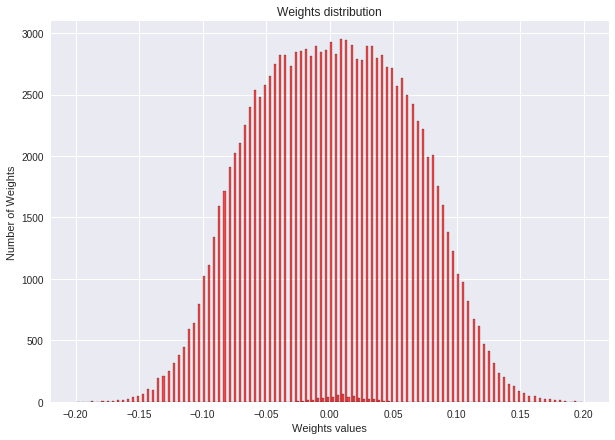

In [0]:
#plot initial weight distribution
ax = dist_plot(dense3_w,plt_range= (-0.2, 0.2))
ax.set_title('Weights distribution')
ax.set_xlabel('Weights values')
ax.set_ylabel('Number of Weights')

The above plot shows the initial weight distribution 

In [0]:
#creating new weight matrix for last dense layer 
dense3_w[0] = dense3_w_new
dense3_w[1] = new_bias

Text(0,0.5,'Number of Weights')

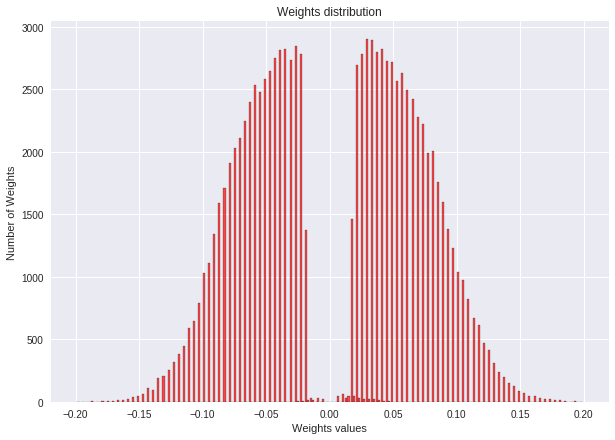

In [0]:
#plot new weight distribution
ax = dist_plot(dense3_w,plt_range= (-0.2, 0.2))
ax.set_title('Weights distribution')
ax.set_xlabel('Weights values')
ax.set_ylabel('Number of Weights')

From the above plot , we can see that low weights have been removed 

Creating new CNN model by changing the shape and weights of last dense layer

In [0]:

new_model = create_new_model(new_OutShape, x_train, y_train, x_test, y_test,conv1_w, conv2_w, dense1_w, dense2_w, dense3_w)

10000/10000 [==============================] - 2s 169us/step
Test loss: 13.563403826904297
Test accuracy: 0.067


#### Retraining the model   
Removing the neurons makes the accuracy of the network worse as we are throwing away what the network has learnt , even if it did not have much importance. In order to compensate for this , we need to retrain the model. 

Retraining is done by model.fit(). Here we retrain for less number of epochs and lower learning rate as the model is already trained,we only want to make small changes to tweak the results.

In [0]:
#retrain new model
retrain_new_model(new_model)

Train on 50000 samples, validate on 10000 samples
Epoch 1/10
50000/50000 [==============================] - 12s 232us/step - loss: 8.2301 - acc: 0.3992 - val_loss: 2.9442 - val_acc: 0.5830
Epoch 2/10
50000/50000 [==============================] - 11s 226us/step - loss: 2.3153 - acc: 0.4823 - val_loss: 1.2732 - val_acc: 0.5862
Epoch 3/10
50000/50000 [==============================] - 11s 230us/step - loss: 1.2767 - acc: 0.5802 - val_loss: 1.0784 - val_acc: 0.6526
Epoch 4/10
50000/50000 [==============================] - 11s 211us/step - loss: 1.1134 - acc: 0.6286 - val_loss: 1.0168 - val_acc: 0.6615
Epoch 5/10
50000/50000 [==============================] - 11s 214us/step - loss: 1.0327 - acc: 0.6535 - val_loss: 0.9809 - val_acc: 0.6779
Epoch 6/10
50000/50000 [==============================] - 11s 211us/step - loss: 0.9859 - acc: 0.6692 - val_loss: 0.9494 - val_acc: 0.6872
Epoch 7/10
50000/50000 [==============================] - 11s 222us/step - loss: 0.9466 - acc: 0.6801 - val_loss: 0.

In [0]:
new_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 32, 32, 32)        896       
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 16, 16, 32)        0         
_________________________________________________________________
dropout_7 (Dropout)          (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 16, 16, 64)        18496     
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 8, 8, 64)          0         
_________________________________________________________________
dropout_8 (Dropout)          (None, 8, 8, 64)          0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 4096)              0         
__________

In [0]:
sequential_model_to_ascii_printout(model)

           OPERATION           DATA DIMENSIONS   WEIGHTS(N)   WEIGHTS(%)

               Input   #####     32   32    3
              Conv2D    \|/  -------------------       896     0.1%
                relu   #####     32   32   32
        MaxPooling2D   Y max -------------------         0     0.0%
                       #####     16   16   32
             Dropout    | || -------------------         0     0.0%
                       #####     16   16   32
              Conv2D    \|/  -------------------     18496     2.6%
                relu   #####     16   16   64
        MaxPooling2D   Y max -------------------         0     0.0%
                       #####      8    8   64
             Dropout    | || -------------------         0     0.0%
                       #####      8    8   64
             Flatten   ||||| -------------------         0     0.0%
                       #####        4096
               Dense   XXXXX -------------------    524416    73.5%
                rel

In [0]:
sequential_model_to_ascii_printout(new_model)

           OPERATION           DATA DIMENSIONS   WEIGHTS(N)   WEIGHTS(%)

               Input   #####     32   32    3
              Conv2D    \|/  -------------------       896     0.1%
                relu   #####     32   32   32
        MaxPooling2D   Y max -------------------         0     0.0%
                       #####     16   16   32
             Dropout    | || -------------------         0     0.0%
                       #####     16   16   32
              Conv2D    \|/  -------------------     18496     2.7%
                relu   #####     16   16   64
        MaxPooling2D   Y max -------------------         0     0.0%
                       #####      8    8   64
             Dropout    | || -------------------         0     0.0%
                       #####      8    8   64
             Flatten   ||||| -------------------         0     0.0%
                       #####        4096
               Dense   XXXXX -------------------    524416    76.4%
                rel

### Results
-----------------------------------------------------------------------------------------------------
|        | Inital Model          | Pruned Model  |
| ------------- |:-------------:| -----:|
| Network Size| 5616Kb |5448Kb |
| Number of Parametrs     | 713,546    |  686,312|
| Accuracy | 71.47%    |    70% |

**Summary**  
Network size is reduced by **200kb**   
Accuracy reduced by **1.5%**  
New model has **30k less parameters**

References :  

https://github.com/keras-team/keras/blob/master/examples/cifar10_cnn.py  
https://github.com/ex4sperans/pruning_with_tensorflow  
https://www.tensorflow.org/api_docs/python  
https://gist.github.com/hollance/d15c0cc6004a5479c00ac26bce61ac8d  
https://keras.io/getting-started/faq/  


'''MIT License

Copyright (c) 2018 CSYE-7245 Big Data System and Intelligence Analytics

Permission is hereby granted, free of charge, to any person obtaining a copy
of this software and associated documentation files (the "Software"), to deal
in the Software without restriction, including without limitation the rights
to use, copy, modify, merge, publish, distribute, sublicense, and/or sell
copies of the Software, and to permit persons to whom the Software is
furnished to do so, subject to the following conditions:

The above copyright notice and this permission notice shall be included in all
copies or substantial portions of the Software.

THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,
FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE
AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER
LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM,
OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE
SOFTWARE.'''